In [1]:
import jax
from jax import jit
from jax import lax
from jax import vmap
import jax.numpy as jnp

from functools import partial

jax.config.update('jax_enable_x64', True)

In [2]:
import math
import numpy as np
import plotly.express as px
import IPython
import matplotlib.pyplot as plt 
import ipywidgets as widgets

%config InlineBackend.figure_formats = ['svg']

In [3]:
from jax_control_algorithms.trajectory_optimization import Solver, constraint_geq, constraint_leq
from jax_control_algorithms.ui import manual_investigate, solve_and_plot
from jax_control_algorithms.common import rk4

def make_time_vectors(X_opt, U_opt):
    # make time vectors
    t_X = jnp.linspace(0, X_opt.shape[0]-1, X_opt.shape[0])
    t_U = jnp.linspace(0, U_opt.shape[0]-1, U_opt.shape[0])
    
    return t_X, t_U

In [4]:
test_results = []

# cart pendulum

In [5]:
def problem_def_cart_pendulum(n_steps, dt):
        
    def model(x, u, k, Theta):
        del k
        
        a,    = Theta['a'], 
        
        f_y = jnp.squeeze(u)
        
        y_dot, y,    = x[0], x[1],
        theta_dot, theta,  = x[2], x[3],

        
        m_c, m_p = 2.0, 1.0
        l = 1.0
        g = 9.81
        
        tmp = m_c + m_p * jnp.sin(theta)**2
        
        y_dd = 1 / ( tmp ) * (
            f_y + m_p * jnp.sin(theta) * (l * theta_dot**2 + g*jnp.cos(theta) )
        )
        
        theta_dd = 1 / ( l * tmp ) * (
            -f_y*jnp.cos(theta) - m_p*l*theta_dot**2 * jnp.cos(theta)*jnp.sin(theta) - (m_c + m_p)*g*jnp.sin(theta)
        )

        x_dot = jnp.array([
            
            # cart system
            y_dd,
            y_dot,
            
            # pendulum system
            theta_dd,
            theta_dot,
            
        ])

        # cost + diff u
        J = Theta['wu'] * u**2
        
        return x_dot, J

    def f(x, u, k, theta):
        x_dot, _ = model(x, u, k, theta)
        return x_dot

    def g(x, u, k, theta):
        
        x_dot, _ = model(x, u, k, theta)
        return 

    def running_cost(x, u, k, theta):
        
        x_dot, J  = model(x, u, k, theta)
        return J
        
    def terminal_state_eq_constraints(x_final, theta):
        
        return jnp.array([
            x_final[0] - theta['y_dot_final'],           # != 0
            x_final[1] - theta['y_final'],           # != 0
            x_final[2] - theta['phi_dot_final'],           # != 0
            x_final[3] - theta['phi_final'],           # != 0
        ])
    
    def inequ_constraints(x, u, k, theta):
        
        u = u[:,0]
        
        # constraints
        c_ineq = jnp.array([
            constraint_geq( u, theta['u_min'] ),
            constraint_leq( u, theta['u_max'] ),
            
        ])
        
        # x_dot, P_transmission, P_yield, J, c_ineq = model(x, u, k, theta)
        return c_ineq

    def make_guess(x0, theta): # TODO: add theta to the solver
                
        U_guess = jnp.zeros( (n_steps, 1) )
        X_guess = jnp.vstack((
            jnp.linspace( x0[0], theta['y_dot_final'], n_steps),
            jnp.linspace( x0[1], theta['y_final'], n_steps),
            
            jnp.linspace( x0[2], theta['phi_dot_final'], n_steps),
            jnp.linspace( x0[3], theta['phi_final'], n_steps),
            
        )).T
        
        return X_guess, U_guess
    
    theta = { 
        'a'             : 5.0, 
        'wu'            : 1.00,
        'u_min'         : -2.5,
        'u_max'         : 2.5,
        
        'y_dot_final'   : 0.0,
        'y_final'       : 1.0,

        'phi_dot_final' : 0.0,
        'phi_final'     : jnp.pi,
    }
    
    
    x0 = jnp.array([ 
        0.0, 0.0,
        0.0, 0.0,
    ])
    
    #
    f_dscr = rk4(f, dt)

    return f_dscr, g, running_cost, terminal_state_eq_constraints, inequ_constraints, theta, x0, make_guess

f_dscr, g, running_cost, terminal_state_eq_constraints, inequ_constraints, theta, x0, make_guess = problem_def_cart_pendulum(50, 0.1)



In [6]:
jnp.rad2deg( jnp.pi )

Array(180., dtype=float64, weak_type=True)

In [7]:
def plot_cart_pendulum(X_opt, U_opt, system_outputs, Theta):

    # prepare data
    u = U_opt[:,0]
    y_dot, y =  X_opt[:,0], X_opt[:,1]
    theta_dot, theta =  X_opt[:,2], X_opt[:,3]

    _ = system_outputs # unpack output variable (return of function g)

    # make time vectors
    t_X, t_U = make_time_vectors(X_opt, U_opt)
    
    # Create a figure and two subplots
    fig, (ax1, ax2, ax3, ) = plt.subplots(3, 1, sharex=True, figsize=(4, 6))

    ax1.plot( t_X, y_dot, 'r', label='y_dot')
    ax1.plot( t_X, y, 'k', label='y')
    ax1.plot(
        [ t_X[0], t_X[-1] ], 
        jnp.array([Theta['y_final'], Theta['y_final']]), 'k:',
        label='y_final'
    )
    
    ax1.legend()
    ax1.set_ylabel(' []')

    # theta
    ax2.plot( t_X, jnp.rad2deg(theta_dot), 'r', label='theta_dot')
    ax2.plot( t_X, jnp.rad2deg(theta), 'k', label='theta')
    ax2.plot(
        [ t_X[0], t_X[-1] ], 
        jnp.array([Theta['phi_final'], Theta['phi_final']]), 'k:',
        label='theta_final'
    )
    
    ax2.legend()
    ax2.set_ylabel(' []')

        
    # 
    ax3.plot( t_U, u, 'k', label='u' )    
    ax3.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([Theta['u_min'], Theta['u_min']]), ':k',
        label='u_min'
    )
    ax3.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([Theta['u_max'], Theta['u_max']]), ':k',
        label='u_max'
    )
    
    ax3.legend()
    ax3.set_ylabel('u []')

    # Show the plot
    plt.show()

In [8]:
sliders = {
        'a'     : widgets.FloatSlider(min=0.0,  max=1.0, step=0.01,  value=0.0,  description='a'),
        'u_min' : widgets.FloatSlider(min=-100,  max=0,   step=0.01,  value=-100,   description='u_min'),
        'u_max' : widgets.FloatSlider(min=0,    max=100,  step=0.01,  value=100,    description='u_max'),
}

solver = Solver( partial(problem_def_cart_pendulum, n_steps = 50, dt=0.1) )
solver.max_float32_iterations = 0

#solver.lam = 1.15
solver.max_iter_boundary_method = 100
solver.c_eq_init = 1000

def set_theta_fn(solver, a, u_min, u_max):
        solver.theta['a'] = a
        solver.theta['u_min'] = u_min
        solver.theta['u_max'] = u_max

In [9]:
ui, output_box, print_output, plot_output = manual_investigate(solver, sliders, set_theta_fn, plot_cart_pendulum )
display(ui, plot_output, print_output)

GridBox(children=(FloatSlider(value=0.0, description='a', max=1.0, step=0.01), FloatSlider(value=-100.0, descr…

Output()

Output()

In [10]:
test_results.append( ['cart_pendulum', solver.success ] )

# Animate the results

In [11]:
cart_position = solver.X_opt[:,1]
pendulum_angle = -solver.X_opt[:,3] + jnp.pi

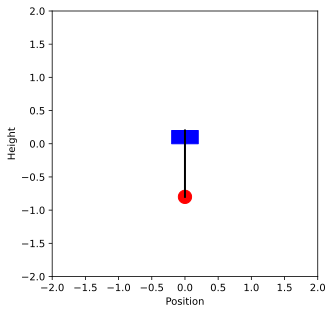

In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Function to update the animation frame
def update(frame):
    ax.clear()
    
    # Define the cart dimensions
    cart_width = 0.4
    cart_height = 0.2

    # Draw the cart
    cart = plt.Rectangle((cart_position[frame] - cart_width / 2, 0), cart_width, cart_height, fill=True, color='blue')
    ax.add_patch(cart)

    # Define the pendulum dimensions
    pendulum_length = 1.0  # Length of the pendulum rod

    # Calculate the pendulum bob position
    pendulum_bob_x = cart_position[frame] + pendulum_length * np.sin(pendulum_angle[frame])
    pendulum_bob_y = cart_height + pendulum_length * np.cos(pendulum_angle[frame])

    # Draw the pendulum rod
    pendulum_rod, = ax.plot([cart_position[frame], pendulum_bob_x], [cart_height, pendulum_bob_y], color='black', linewidth=2)

    # Draw the pendulum bob
    pendulum_bob = plt.Circle((pendulum_bob_x, pendulum_bob_y), 0.1, fill=True, color='red')
    ax.add_patch(pendulum_bob)

    # Set axis limits and labels
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Position')
    ax.set_ylabel('Height')


# Create the figure and axis
fig, ax = plt.subplots()

# Create the animation
ani = FuncAnimation(fig, update, frames=cart_position.shape[0], repeat=False, interval=100)

# Save the animation as an MP4 file
ani.save('cart_pendulum_animation.mp4', writer='ffmpeg')

# Display the saved animation
from IPython.display import Video
Video("cart_pendulum_animation.mp4")


# Verify

In [13]:
def verify_test_results(test_results):
    for r in test_results:
        if not r[1]:
            raise BaseException('Test ' + r[0] + ' failed')
            
verify_test_results(test_results)